In [1]:
# ライブラリのインポート
from datetime import datetime, timedelta
import talib as ta
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [2]:
def import_data(kind, reference='yahoo'):
    data_master = data.DataReader(kind, reference, '2000-01-01', end)
    data_master.reset_index(drop=False, inplace=True)
    data_master['Date'] = pd.to_datetime(data_master['Date'])
    return data_master

In [3]:
# 開始日時と終了日時
start, end = '2021-01-01', '2021-12-01'
# 使用する銘柄
kind = '^N225'

In [4]:
# データのインポートを行う
data_master = import_data(kind=kind)
# Dateをインデックスに指定
data_master.set_index('Date',inplace=True)
data_master

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,19187.609375,18937.449219,18937.449219,19002.859375,0.0,19002.859375
2000-01-05,19003.509766,18221.820312,19003.509766,18542.550781,0.0,18542.550781
2000-01-06,18582.740234,18168.269531,18574.009766,18168.269531,0.0,18168.269531
2000-01-07,18285.730469,18068.099609,18194.050781,18193.410156,0.0,18193.410156
2000-01-11,18887.560547,18246.099609,18246.099609,18850.919922,0.0,18850.919922
...,...,...,...,...,...,...
2021-11-25,29570.419922,29444.449219,29469.650391,29499.279297,50700000.0,29499.279297
2021-11-26,29332.990234,28605.609375,29324.470703,28751.619141,72900000.0,28751.619141
2021-11-29,28776.339844,28187.119141,28337.960938,28283.919922,85900000.0,28283.919922


In [5]:
# windows: 移動平均日数
windows = [2, 3, 5, 10, 20, 40, 80]
# macd_windows: MACD用の移動平均日数
macd_windows = [10, 20, 30]
# deviation: ボリンジャーバンド用の偏差
deviation = [1, 2, 3]
# rsi_upper, rsi_lower: RSIの買いすぎ売られすぎ指標
rsi_upper, rsi_lower = 70, 30
# di_span, dx_span: DI,DXの計算期間日数
di_span, dx_span = 14, 14

# データのインポートを行う
data_master = import_data(kind=kind)
# テクニカル指標を作成
# data_technical, data_logic, data_graph = data_arrange(data_master)

In [6]:
data_technical=data_master.copy()
data_technical.set_index('Date',inplace=True)
# s = data_technical['Close']

data_graph = []
# data_logic_no_stack=[]
# data_logic_name_stack=[]
data_logic_complile=[]
data_graph = []

GCDC_signal_COL=[]
MACD_signal_COL=[]
RSI_signal_COL=[]
BB_signal_COL=[]
GCDC_MACD_signal_COL=[]
GCDC_RSI_signal_COL=[]
GCDC_RSI_MACD_signal_COL=[]
BB_RSI_signal_COL=[]
DMI_signal_COL=[]

def gen_counter():
    """呼び出すごとにカウントを上げるカウンタを生成する"""
    # クロージャ _counter で利用する現在のカウント
    count = 0
    def _counter(reset=False):        
        nonlocal count # 関数の外にある count を更新したいので nonlocal 宣言をする
        if reset:
            count = 0
        count += 1
        return count
    return _counter

logic_counter = gen_counter()
GCDC_signal_counter=gen_counter()
MACD_signal_counter=gen_counter()
RSI_signal_counter=gen_counter()
BB_signal_counter=gen_counter()
DMI_signal_counter=gen_counter()

def Average_SMA(data,prices,window):
    for i in window:
        data['sma_'+str(i)]=prices.rolling(window=i).mean()
    return data

def Average_EMA(data,prices,window):
    for i in window:
        data['ema_'+str(i)]=prices.ewm(span=i).mean()
    return data

def RSI(data,prices,window):
    for i in window:
        data['rsi_' + str(i)] = ta.RSI(prices, timeperiod=i)
    return data

def bollingerBands(data,prices,window):
    data_sma=Average_SMA(data=data,prices=data[['Close']],window=windows)   
    for i in window:    
        for j in deviation:
            # upper_sigma
            data['upper_' + str(i) + '_dev_' + str(j)] = data_sma['sma_' + str(i)] + data['Close'].rolling(window=i).std(ddof=0) * j
            #lower_sigma
            data['lower_' + str(i) + '_dev_' + str(j)] = data_sma['sma_' + str(i)] - data['Close'].rolling(window=i).std(ddof=0) * j

            # ボリンジャーバンドの上か下か
            data['upper_check' + str(i) + '_dev_' + str(j)] = data['Close'] >= data['upper_' + str(i) + '_dev_' + str(j)]
            data['lower_check' + str(i) + '_dev_' + str(j)] = data['Close'] <= data['lower_' + str(i) + '_dev_' + str(j)]
    return data


# 実体
def Candlestick_entity(data):
    data['entity'] = abs(data['Open'] - data['Close'])
    return data

# ローソクの長さ
def Candlestick_size(data):
    data['size'] = data['High'] - data['Low']
    return data

# True＝陽
def Candlestick_Yin_yang(data):
    data['陽陰'] = data['Close'] > data['Open']
    return data

# 上ヒゲの長さ
def Candlestick_upper_hige(data):
    data['upper_hige'] = data.apply(lambda x: (x['High'] - x['Close']) if x['Close'] >= x['Open'] else (x['High'] - x['Open']),axis=1)
    return data

# 下ヒゲの長さ
def Candlestick_lower_hige(data):
    data['lower_hige'] = data.apply(lambda x: (x['Open'] - x['Low'] ) if x['Close'] >= x['Open'] else (x['Close'] - x['Low']),axis=1)
    return data

# 上ヒゲ、実体、下ヒゲのpercentage
def Candlestick_size_percentage(data):
    size_ = Candlestick_size(data)['size']
    upper_hige_ = Candlestick_upper_hige(data)['upper_hige']
    entity_ = Candlestick_entity(data)['entity']
    lower_hige_ = Candlestick_lower_hige(data)['lower_hige'] 
    
    data['upper_size'] = upper_hige_ / size_
    data['entity_seze'] = entity_ / size_
    data['lower_size'] =  lower_hige_ / size_

    return data


def DM(data):
    pos_DM = (data['High'] - data['High'].shift(1))
    neg_DM = (data['Low'].shift(1) - data['Low'])
    pos_DM.loc[pos_DM < 0] = 0
    pos_DM.loc[pos_DM - neg_DM < 0] = 0
    neg_DM.loc[neg_DM < 0] = 0
    neg_DM.loc[neg_DM - pos_DM < 0] = 0
    return pos_DM,neg_DM

def TrueRange(data):
    high_low = (data['High'] - data['Low']).abs()
    high_yest_close = (data['High'] - data['Close'].shift(1)).abs()
    low_yest_close = (data['Low'] - data['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_yest_close, low_yest_close], axis=1).max(axis=1)
    return tr

def DMI(data):
    tr=TrueRange(data)
    pos_DM,neg_DM=DM(data)
    
    data['+DI'] = pos_DM.rolling(di_span).sum() / tr.rolling(di_span).sum() * 100
    data['-DI'] = neg_DM.rolling(di_span).sum() / tr.rolling(di_span).sum() * 100
    data['DX'] = (data_technical['+DI'] - data_technical['-DI']) / (data_technical['+DI'] + data_technical['-DI'])
    data['ADX'] = data_technical['DX'].ewm(span=dx_span).mean()
    data['ADX_diff'] = data_technical['ADX'].diff(1)
    return data


def GCDC_signal(data):
    c=GCDC_signal_counter()
    if c <2:
        data=Average_SMA(data=data,prices=data_technical['Close'],window=windows)
        for i in windows[::-1]:
            for j in windows:
                if i>j:
                    n=logic_counter()
                    logic1 = 'logic' + str('{0:05d}'.format(n))
                    data['sma_' + str(i)+'-'+str(j)] = data['sma_' + str(i)] - data['sma_'+str(j)]

                    data[logic1 + '_sell'] = (data['sma_' + str(i) + '-' + str(j)] * data['sma_' + str(i) + '-' + str(j)].shift(1) < 0) & (data['sma_'+str(i)] > data['sma_'+str(j)])
                    data[logic1 + '_buy'] = (data['sma_' + str(i) + '-' + str(j)] * data['sma_' + str(i) + '-' + str(j)].shift(1) < 0) & (data['sma_' + str(i)] < data['sma_'+str(j)])
                    data_logic_complile.append([logic1,'sma_slope_' + str(i)+'-'+str(j)])
                    GCDC_signal_COL.append([logic1,'sma_slope_' + str(i)+'-'+str(j),i,j])
#                 data_logic_no_stack.append(logic1)
#                 data_logic_name_stack.append('sma_' + str(i)+'-'+str(j))
#                 p(logic1)
#                 data_logic2 = pd.concat([data_logic2, pd.DataFrame([logic1, 'sma_slope_' + str(i) + '-' + str(j)]).T])
                data_graph.append([logic1, ['sma_' + str(i), 'sma_' + str(j)]])
    return data


def MACD_signal(data):
    c=MACD_signal_counter()
    if c <2:    
        for k in macd_windows[::-1]:
            for l in macd_windows:
                if k > l:
                    # MACDの買いシグナルと売りシグナル
                    n=logic_counter()
                    logic2 = 'logic' + str('{0:05d}'.format(n))
                    macd, macdsignal, macdhist = ta.MACD(data['Close'], fastperiod=l, slowperiod=k, signalperiod=l)
                    data['macd_'+ str(k)+'-'+str(l)] = macd
                    data['macdsignal_'+ str(k)+'-'+str(l)] = macdsignal
                    data['macdhist_'+ str(k)+'-'+str(l)] = macdhist
                    data[logic2 + '_sell'] = ((data['macdhist_'+ str(k)+'-'+str(l)].shift(1) > 0) & (data['macdhist_'+ str(k)+'-'+str(l)] < 0))
                    data[logic2 + '_buy'] = ((data['macdhist_'+ str(k)+'-'+str(l)].shift(1) <= 0) & (data['macdhist_'+ str(k)+'-'+str(l)] >= 0))       
                    data_logic_complile.append([logic2,'MACD_' + str(k) + '-' + str(l)])
                    MACD_signal_COL.append([logic2,'MACD_' + str(k) + '-' + str(l),k,l])
                    data_graph.append([logic2, ['macd_'+ str(k)+'-'+str(l), 'macdsignal_'+ str(k)+'-'+str(l), 'macdhist_'+ str(k)+'-'+str(l)]])               
    return data


def GCDC_MACD_signal(data):
    data=GCDC_signal(data)
    data=MACD_signal(data)
    for i in range(len(GCDC_signal_COL)):
        for j in range(len(MACD_signal_COL)):
            n=logic_counter()
            logic1=GCDC_signal_COL[i][0]
            logic2=MACD_signal_COL[j][0]

            logic5 = 'logic' + str('{0:05d}'.format(n))
            data[logic5 + '_sell'] = (data[logic1 + '_sell'] == True) & (data[logic2 + '_sell'] == True)
            data[logic5 + '_buy'] = (data[logic1 + '_buy'] == True) & (data[logic2 + '_buy'] == True)

            data_logic_complile.append([logic5, 'sma_slope_'+str(GCDC_signal_COL[i][2])+'-'+str(GCDC_signal_COL[i][3])+'_macdhist_'+ str(MACD_signal_COL[j][2])+'-'+str(MACD_signal_COL[j][3])])
            GCDC_MACD_signal_COL.append([logic5, 'sma_slope_'+str(GCDC_signal_COL[i][2])+'-'+str(GCDC_signal_COL[i][3])+'_macdhist_'+ str(MACD_signal_COL[j][2])+'-'+str(MACD_signal_COL[j][3])])
            data_graph.append([logic5, ['sma_' + str(GCDC_signal_COL[i][2]), 'sma_' + str(GCDC_signal_COL[i][3]), 'macdhist_'+ str(MACD_signal_COL[j][2])+'-'+str(MACD_signal_COL[j][3])]])
    return data


def RSI_signal(data):
    c=RSI_signal_counter()
    if c <2:
        data=RSI(data=data_technical,prices=data_technical['Close'],window=windows)
        for i in windows[::-1]:
            n=logic_counter()
            logic3 = 'logic' + str('{0:05d}'.format(n))
            data[logic3 + '_sell'] = (data['rsi_' + str(i)] >= rsi_upper)
            data[logic3 + '_buy'] = (data['rsi_' + str(i)] <= rsi_lower)       
            data_logic_complile.append([logic3,'RSI_' + str(i)])
            RSI_signal_COL.append([logic3,'RSI_' + str(i),i])
            data_graph.append([logic3, ['rsi_' + str(i)]])
    return data


def GCDC_RSI_signal(data):
    data=GCDC_signal(data)
    data=RSI_signal(data)
    for i in range(len(GCDC_signal_COL)):
        for r in range(len(RSI_signal_COL)):
            n=logic_counter()
            logic1=GCDC_signal_COL[i][0]
            logic3=RSI_signal_COL[r][0]       
            logic4 = 'logic' + str('{0:05d}'.format(n))
            data[logic4 + '_sell'] = (data[logic1 + '_sell'] == True) & (data[logic3 + '_sell'] == True)
            data[logic4 + '_buy'] = (data[logic1 + '_buy'] == True) & (data[logic3 + '_buy'] == True)
            data_logic_complile.append([logic4, 'sma_slope_'+str(GCDC_signal_COL[i][2])+'-'+str(GCDC_signal_COL[i][3])+'_RSI_'+str(RSI_signal_COL[r][2])])
            GCDC_RSI_signal_COL.append([logic4, 'sma_slope_'+str(GCDC_signal_COL[i][2])+'-'+str(GCDC_signal_COL[i][3])+'_RSI_'+str(RSI_signal_COL[r][2])])
            data_graph.append([logic4, ['sma_' + str(GCDC_signal_COL[i][2]), 'sma_' + str(GCDC_signal_COL[i][3]), 'rsi_' + str(RSI_signal_COL[r][2])]])
    return data    


def GCDC_RSI_MACD_signal(data):
    data=GCDC_signal(data)
    data=RSI_signal(data)
    data=MACD_signal(data)
    for i in range(len(GCDC_signal_COL)):
        for r in range(len(RSI_signal_COL)):
            for j in range(len(MACD_signal_COL)):
                n=logic_counter()
                logic5 = 'logic' + str('{0:05d}'.format(n))
                
                logic1=GCDC_signal_COL[i][0]
                logic3=RSI_signal_COL[r][0]    
                logic2=MACD_signal_COL[j][0]               
    
                data_technical[logic5 + '_sell'] = (data_technical[logic2 + '_sell'] == True) & (data_technical[logic1 + '_sell'] == True) & (data_technical[logic3 + '_sell'] == True)
                data_technical[logic5 + '_buy'] = (data_technical[logic2 + '_buy'] == True) & (data_technical[logic1 + '_buy'] == True) & (data_technical[logic3 + '_buy'] == True)  
    
                data_logic_complile.append([logic5, 'sma_slope_'+str(GCDC_signal_COL[i][2])+'-'+str(GCDC_signal_COL[i][3])+'_rsi_'+str(RSI_signal_COL[r][2])+'_macdhist_'+ str(MACD_signal_COL[j][2])+'-'+str(MACD_signal_COL[j][3])])
                GCDC_RSI_MACD_signal_COL.append([logic5, 'sma_slope_'+str(GCDC_signal_COL[i][2])+'-'+str(GCDC_signal_COL[i][3])+'_rsi_'+str(RSI_signal_COL[r][2])+'_macdhist_'+ str(MACD_signal_COL[j][2])+'-'+str(MACD_signal_COL[j][3])])
        
                data_graph.append([logic5, ['sma_' + str(GCDC_signal_COL[i][2]), 'sma_' + str(GCDC_signal_COL[i][3]), 'rsi_' + str(RSI_signal_COL[r][2]), 'macdhist_'+ str(MACD_signal_COL[j][2])+'-'+str(MACD_signal_COL[j][3])]])
    return data   


def BB_signal(data):
    c=BB_signal_counter()
    if c <2:    
        data=bollingerBands(data=data_technical,prices=data_technical['Close'],window=windows)
        data=Average_SMA(data=data_technical,prices=data_technical['Close'],window=windows)
        for i in windows[::-1]:    
            for dev in deviation:
                n=logic_counter()
                logic6 = 'logic' + str('{0:05d}'.format(n))

                data[logic6 + '_sell'] = data['Close'] >= data['upper_' + str(i) + '_dev_' + str(dev)]
                data[logic6 + '_buy'] = data['Close'] <= data['lower_' + str(i) + '_dev_' + str(dev)]
                
                data_logic_complile.append([logic6, 'bb_'+str(i) + '_dev_' + str(dev)])
                BB_signal_COL.append([logic6, 'bb_'+str(i) + '_dev_' + str(dev),i,dev])
                
                data_graph.append([logic6, ['Close', 'lower_' + str(i) + '_dev_' + str(dev), 'upper_' + str(i) + '_dev_' + str(dev)]])
    return data


def BB_RSI_signal(data):
    data=BB_signal(data)
    data=RSI_signal(data)
    for r in range(len(RSI_signal_COL)):
        for b in range(len(BB_signal_COL)):
  
            n=logic_counter()
            logic7 = 'logic' + str('{0:05d}'.format(n))
        
#             logic1=GCDC_signal_COL[i][0]
            logic3=RSI_signal_COL[r][0]    
#             logic2=MACD_signal_COL[j][0]    
            logic6=BB_signal_COL[b][0]  
            
            BB_signal_SMA=str(BB_signal_COL[b][2])
            BB_signal_dev=str(BB_signal_COL[b][3])
            RSI_signal_SMA=str(RSI_signal_COL[r][2])
            
            
            data[logic7 + '_sell'] = (data[logic3 + '_sell'] == True) & (data[logic6 + '_sell'] == True)
            data[logic7 + '_buy'] = (data[logic3 + '_buy'] == True) & (data[logic6 + '_buy'] == True)
            
            data_logic_complile.append([logic7, 'bb_'+ BB_signal_SMA + '_dev' + BB_signal_dev+'_rsi'+RSI_signal_SMA])
            BB_RSI_signal_COL.append([logic7, 'bb_'+ BB_signal_SMA + '_dev' + BB_signal_dev+'_rsi'+RSI_signal_SMA])

            data_graph.append([logic7, ['Close', 'lower_' + BB_signal_SMA + '_dev_' + BB_signal_dev, 'upper_' + BB_signal_SMA + '_dev_' + BB_signal_dev, 'rsi_' + RSI_signal_SMA]])

    return data



def DMI_signal(data):
    c=DMI_signal_counter()
    if c <2: 
        data=DMI(data)
        n=logic_counter()
        
        logic = 'logic' + str('{0:05d}'.format(n))
        
        data['di_diff'] = -1 * data['+DI'] + data['-DI']
        data[logic + '_sell'] = (data['di_diff'] * data['di_diff'].shift(1) < 0) & (data['+DI'] < data['-DI']) & (data['ADX_diff'] > 0)
        data[logic + '_buy'] = (data['di_diff'] * data['di_diff'].shift(1) < 0) & (data['+DI'] > data['-DI']) & (data['ADX_diff'] > 0)

        data_logic_complile.append([logic, 'DMI'])
        DMI_signal_COL.append([logic, 'DMI'])
        data_graph.append([logic, ['+DI', '-DI', 'ADX']])

    return data


def DropNA(data):
    data = data.dropna(how='any')
    return data

def TrueFalseConversion(data):
    data.replace({False: 0, True: 1}, inplace=True)
    return data

def Data_Extraction(data,start):
    data.reset_index(drop=False, inplace=True)
    start_timestamp= pd.to_datetime(start)
    data = data.set_index('Date')
    data = data.loc[start_timestamp:, :]
    data.reset_index(drop=False, inplace=True)
    data['idx_technical'] = data.index
    return data

In [128]:
# data_technical=GCDC_RSI_signal(data_technical)
# data_technical

In [129]:
data_technical=Average_SMA(data=data_technical,prices=data_technical['Close'],window=windows)
data_technical=Average_EMA(data=data_technical,prices=data_technical['Close'],window=windows)
data_technical=RSI(data=data_technical,prices=data_technical['Close'],window=windows)
data_technical=bollingerBands(data=data_technical,prices=data_technical['Close'],window=windows)
data_technical=Candlestick_entity(data_technical)
data_technical=Candlestick_size(data_technical)
data_technical=Candlestick_Yin_yang(data_technical)
data_technical=Candlestick_upper_hige(data_technical)
data_technical=Candlestick_lower_hige(data_technical)
data_technical=Candlestick_size_percentage(data_technical)
data_technical=DMI(data_technical)
data_technical=GCDC_signal(data_technical)
data_technical=MACD_signal(data_technical)
data_technical=GCDC_MACD_signal(data_technical)
data_technical=RSI_signal(data_technical)
data_technical=GCDC_RSI_signal(data_technical)
data_technical=GCDC_RSI_MACD_signal(data_technical)
data_technical=BB_signal(data_technical)
data_technical=BB_RSI_signal(data_technical)
data_technical=DMI_signal(data_technical)
data_technical

,High,Low,Open,Close,Volume,Adj Close,sma_2,sma_3,sma_5,sma_10,...,logic00847_buy,logic00848_sell,logic00848_buy,logic00849_sell,logic00849_buy,logic00850_sell,logic00850_buy,di_diff,logic00851_sell,logic00851_buy
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,19187.609375,18937.449219,18937.449219,19002.859375,0.0,19002.859375,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,False,False
2000-01-05,19003.509766,18221.820312,19003.509766,18542.550781,0.0,18542.550781,18772.705078,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,False,False
2000-01-06,18582.740234,18168.269531,18574.009766,18168.269531,0.0,18168.269531,18355.410156,18571.226562,NaN,NaN,...,False,False,True,False,False,False,False,NaN,False,False
2000-01-07,18285.730469,18068.099609,18194.050781,18193.410156,0.0,18193.410156,18180.839844,18301.410156,NaN,NaN,...,False,False,False,False,False,False,False,NaN,False,False
2000-01-11,18887.560547,18246.099609,18246.099609,18850.919922,0.0,18850.919922,18522.165039,18404.199870,18551.601953,NaN,...,False,True,False,False,False,False,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,29570.419922,29444.449219,29469.650391,29499.279297,50700000.0,29499.279297,29400.969727,29525.349609,29584.115625,29608.165820,...,False,False,False,False,False,False,False,15.064869,False,False
2021-11-26,29332.990234,28605.609375,29324.470703,28751.619141,72900000.0,28751.619141,29125.449219,29184.519531,29414.707422,29555.541797,...,False,False,True,False,False,False,False,26.017571,False,False
2021-11-29,28776.339844,28187.119141,28337.960938,28283.919922,85900000.0,28283.919922,28517.769531,28844.939453,29122.317578,29422.936719,...,False,False,True,False,False,False,False,32.150325,False,False


In [130]:
data_logic = pd.DataFrame(data_logic_complile, columns=['logic_number','logic_name'])
data_logic.to_csv('logc list function.csv')
data_logic

# df_merge2=list(zip(data_logic_no_stack,data_logic_name_stack))
# df_merge2
# df_merge3=pd.DataFrame(df_merge2, columns=['logic_number','logic_name'])
# df_merge3

,logic_number,logic_name
0,logic00001,sma_slope_80-2
1,logic00002,sma_slope_80-3
2,logic00003,sma_slope_80-5
3,logic00004,sma_slope_80-10
4,logic00005,sma_slope_80-20
...,...,...
846,logic00847,bb_3_dev3_rsi2
847,logic00848,bb_2_dev1_rsi2
848,logic00849,bb_2_dev2_rsi2
849,logic00850,bb_2_dev3_rsi2


In [131]:
a=len(RSI_signal_COL)
b=len(GCDC_signal_COL)
c=len(MACD_signal_COL)
d=len(GCDC_MACD_signal_COL)
e=len(GCDC_RSI_signal_COL)
f=len(GCDC_RSI_MACD_signal_COL)
g=len(BB_signal_COL)
h=len(BB_RSI_signal_COL)
i=len(DMI_signal_COL)

print(f'RSI_signal\n{a}\n')
print(f'GCDC_signal\n{b}\n')
print(f'MACD_signal_COL\n{c}\n')
print(f'GCDC_MACD_signal_COL\n{d}\n')
print(f'GCDC_RSI_signal\n{e}\n')
print(f'GCDC_RSI_MACD_signal_COL\n{f}\n')
print(f'BB_signal_COL\n{g}\n')
print(f'BB_RSI_signal_COL\n{h}\n')
print(f'DMI_signal_COL\n{i}\n')
print(f'TTL\n{a+b+c+d+e+f+g+h+i}\n')

RSI_signal
7

GCDC_signal
21

MACD_signal_COL
3

GCDC_MACD_signal_COL
63

GCDC_RSI_signal
147

GCDC_RSI_MACD_signal_COL
441

BB_signal_COL
21

BB_RSI_signal_COL
147

DMI_signal_COL
1

TTL
851



In [132]:
data_technical=DropNA(data_technical)
data_technical=TrueFalseConversion(data_technical)
data_technical=Data_Extraction(data=data_technical,start='2021-01-01')
data_technical.to_csv('data_technical_tentative.csv')

In [133]:
# data_graph

In [134]:

'''
資産計算を行う関数
'''
def close_order(asset, have_position, order_price, cnt_win, cnt_lose, price, diff_price, unit):
    if(have_position == 'buy'):  # 買いポジションの場合
        diff_price = price - order_price - spreed
    elif(have_position == 'sell'):  # 売りポジションの場合
        diff_price = order_price - price - spreed
    if(diff_price > 0):  # 勝った場合
        cnt_win += 1
        result = 'win'
    else:
        cnt_lose += 1
        result = 'lose'

    asset = asset + diff_price * unit
    have_position = 'neutral'
    return asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit 

def check_price(data_technical, use_data):
    # 結果を記載するデータフレーム
    data_result = pd.DataFrame()
    # 警告が出ないようにデータフレームをコピー
    data = data_technical.copy()
    # 資産
    asset = ASSET
    # 各々の変数の初期値
    have_position = 'neutral'
    order_price, diff_price, cnt_win, cnt_lose, unit = 0, 0, 0, 0, 0
    # テクニカル指標のカラム名
    col_buy = use_data + '_buy'
    col_sell = use_data + '_sell'

    # for文を使ってそれぞれの取引の計算結果を調べる
    for idx_technical, open_price, buy_signal, sell_signal in zip(data['idx_technical'], data['Close'], data[col_buy], data[col_sell]):
        if(have_position == 'buy'):
            if(open_price - order_price > profit_diff):  # 買い利益確定
                start_position = have_position
                asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit = close_order(asset, have_position, order_price, cnt_win, cnt_lose, open_price, diff_price, unit)
                data_result = data_result.append(pd.DataFrame(
                        [ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, price, result, start_position, diff_price, asset, unit]).T)
            elif open_price - order_price < loss_diff:  # 買い損切り
                start_position = have_position
                asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit = close_order(asset, have_position, order_price, cnt_win, cnt_lose, open_price, diff_price, unit)
                data_result = data_result.append(pd.DataFrame(
                        [ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, price, result, start_position, diff_price, asset, unit]).T)
        elif(have_position == 'sell'):
            if order_price - open_price > profit_diff:  # 売り利益確定
                start_position = have_position
                asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit  = close_order(
                    asset, have_position, order_price, cnt_win, cnt_lose, open_price, diff_price, unit)
                data_result = data_result.append(pd.DataFrame(
                    [ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, price, result, start_position, diff_price, asset, unit]).T)
            elif order_price - open_price < loss_diff:  # 売り損切り
                start_position = have_position
                asset, have_position, order_price, price, cnt_win, cnt_lose, result, diff_price, unit  = close_order(
                    asset, have_position, order_price, cnt_win, cnt_lose, open_price, diff_price, unit)
                data_result = data_result.append(pd.DataFrame(
                    [ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, price, result, start_position, diff_price, asset, unit]).T)
        elif(have_position == 'neutral'):  # ポジションを持っていない場合
            if (buy_signal == 1):  # 買いシグナルが起きた場合
                # 買い注文
                have_position = 'buy'
                order_price = data['Close'][idx_technical]
                ask_idx = idx_technical
                ask_time = data['Date'][idx_technical]
                unit = (asset - asset % open_price) / open_price
            elif (sell_signal == 1):  # 売りシグナルが起きた場合
                # 売り注文
                have_position = 'sell'
                order_price = data['Close'][idx_technical]
                ask_idx = idx_technical
                ask_time = data['Date'][idx_technical]
                unit = (asset - asset % open_price) / open_price
    # resultのデータフレームを整理
    if (data_result.shape[0] == 0):
#         print('使用したテクニカル指標では取引回数が0回でした。')
        return asset, cnt_win, cnt_lose, data_result
    else:
        data_result.columns = ['ask_time', 'bid_time', 'ask_idx', 'bid_idx', 'ask_price', 'bid_price', 'result', 'order_position', 'diff_price', 'asset', 'unit']
        data_result.reset_index(drop=True, inplace=True)
        return asset, cnt_win, cnt_lose, data_result

'''
資産計算を行なった結果をグラフ化する関数
'''
def data_plot_asset(data_result):
    # 資産の増減のグラフを作成
    data_result_first = pd.DataFrame(['--', pd.to_datetime(start), '--', '--', '--', '--', '--', 'neutral', '--', ASSET, '--']).T
    data_result_first.columns = ['ask_time', 'bid_time', 'ask_idx', 'bid_idx', 'ask_price', 'bid_price', 'result', 'order_position', 'diff_price', 'asset', 'unit']
    data_result_graph = pd.concat([data_result_first, data_result])
    register_matplotlib_converters()
    plt.figure(figsize=(20, 5))
    plt.plot(data_result_graph['bid_time'], data_result_graph['asset'], marker='o')
    plt.title('Changes in Assets')
    plt.ticklabel_format(style='plain',axis='y')
    plt.grid()
    plt.show()
    
'''
資産計算の詳細をグラフ化する関数
'''
def data_plot_info(data_technical, data_result, data_graph, use_data):
    # グラフの最大値と最小値の差を求める
    close_max = data_technical['Close'].max()
    close_min = data_technical['Close'].min()
    close_diff = close_max - close_min

    # 資産運用結果を勝敗について分けたデータフレーム
    results_win = data_result[data_result['result'] == 'win']
    results_lose = data_result[data_result['result'] == 'lose']

    # グラフ描画
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))
    ax = ax.flatten()
    # 折線グラフ
    ax[0].plot(data_technical['Date'], data_technical['Close'], label='Close data')
    for i in data_graph:
        if(i[0] == use_data):
            for col in i[1]:
                ax[1].plot(data_technical['Date'], data_technical[col], label=col)
    # 散布図
    ax[0].scatter(data_result['ask_time'], data_result['ask_price'], marker='o', color='white', s=150, label='asking point', linewidths=2, edgecolors='black', alpha=0.5)
    ax[0].scatter(results_win['bid_time'], results_win['bid_price'], marker='o', color='red', s=150, label='bidding point (win)', linewidths=2, edgecolors='red', alpha=0.5)
    ax[0].scatter(results_lose['bid_time'], results_lose['bid_price'], marker='o', color='skyblue', s=150, label='bidding point (lose)', linewidths=2, edgecolors='blue', alpha=0.5)

    # 注釈の記載
    for start_date, start_price, end_date, end_price in zip(results_win['ask_time'], results_win['ask_price'], results_win['bid_time'], results_win['bid_price']):
        ax[0].annotate(s='', xy=(end_date, end_price), xytext=(start_date, start_price), fontsize=14, arrowprops=dict(facecolor='firebrick', shrink=0.05))
    for start_date, start_price, end_date, end_price in zip(results_lose['ask_time'], results_lose['ask_price'], results_lose['bid_time'], results_lose['bid_price']):
        ax[0].annotate(s='', xy=(end_date, end_price), xytext=(start_date, start_price), fontsize=14, arrowprops=dict(facecolor='skyblue', shrink=0.05))
    for text, end_date, end_price in zip(data_result['result'], data_result['bid_time'], data_result['bid_price']):
        ax[0].text(end_date, end_price + 0.03*close_diff, text, fontsize=13, horizontalalignment='left', verticalalignment='center')
    for text, start_date, start_price in zip(data_result['order_position'], data_result['ask_time'], data_result['ask_price']):
        ax[0].text(start_date, start_price + 0.03*close_diff, text, fontsize=13, horizontalalignment='right', verticalalignment='center')

    # グラフのタイトル、ラベルなどを設定
    ax[0].set_title('Finance Result Graph')
    ax[0].set_xlabel('Date');ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Close')
    ax[0].grid(True);ax[1].grid(True)
    ax[0].legend();ax[1].legend()
    plt.show()

In [135]:
# スタート時の資産
ASSET = 1000000
# 手数料
spreed = 50
# 利確をする価格差(正の値)
profit_diff = 2200
# 損切をする価格差(負の値)
loss_diff = -100

In [136]:
assetdata=[]

In [137]:
for c in range(1,len(data_logic)-1):
    use_data='logic'+str('{0:05d}'.format(c))               
    asset, cnt_win, cnt_lose, data_result = check_price(data_technical, use_data=use_data)
    assetdata.append(asset)

In [138]:
df_asset=pd.DataFrame(assetdata).round().astype(int)
df_asset

,0
0,891902
1,912316
2,918423
3,938513
4,969718
...,...
844,1141819
845,1000000
846,1000000
847,1082022


In [139]:
df_merge2=list(zip(data_logic['logic_number'],data_logic['logic_name'],df_asset[0]))
df_merge3=pd.DataFrame(df_merge2, columns=['logic_number','logic_name','Final Asset'])
df_merge3.sort_values('Final Asset', ascending=False)

,logic_number,logic_name,Final Asset
805,logic00806,bb_2_dev1_rsi5,1411298
91,logic00092,RSI_5,1395486
787,logic00788,bb_80_dev1_rsi5,1257193
793,logic00794,bb_20_dev1_rsi5,1257193
799,logic00800,bb_5_dev1_rsi5,1238669
...,...,...,...
92,logic00093,RSI_3,883127
697,logic00698,bb_3_dev_1,879614
12,logic00013,sma_slope_20-3,843451
14,logic00015,sma_slope_20-10,842410


In [140]:
df_merge3_Asset=df_merge3['Final Asset']
df_merge3_Asset.describe().apply(lambda x: format(x, 'f'))

count        849.000000
mean     1002728.087161
std        44613.668365
min       811011.000000
25%      1000000.000000
50%      1000000.000000
75%      1000000.000000
max      1411298.000000
Name: Final Asset, dtype: object

,ask_time,bid_time,ask_idx,bid_idx,ask_price,bid_price,result,order_position,diff_price,asset,unit
0,2021-01-08,2021-01-13,4,6,28139.029297,28456.589844,lose,sell,-367.560547,987135.380859,35.0
1,2021-01-14,2021-01-25,7,14,28698.259766,28822.289062,lose,sell,-174.029297,981218.384766,34.0
2,2021-01-29,2021-02-15,18,28,27663.390625,30084.150391,win,buy,2370.759766,1064194.976562,35.0
3,2021-02-16,2021-05-12,29,85,30467.75,28147.509766,win,sell,2270.240234,1141383.144531,34.0
4,2021-05-13,2021-07-30,86,140,27448.009766,27283.589844,lose,buy,-214.419922,1132591.927734,41.0
5,2021-08-17,2021-08-19,151,153,27424.470703,27281.169922,lose,buy,-193.300781,1124666.595703,41.0
6,2021-08-20,2021-09-06,154,165,27013.25,29659.890625,win,buy,2596.640625,1231128.861328,41.0
7,2021-09-07,2021-09-08,166,167,29916.140625,30181.210938,lose,sell,-315.070312,1218210.978516,41.0
8,2021-09-09,2021-09-10,168,169,30008.189453,30381.839844,lose,sell,-423.650391,1201264.962891,40.0
9,2021-09-13,2021-09-14,170,171,30447.369141,30670.099609,lose,sell,-272.730469,1190628.474609,39.0


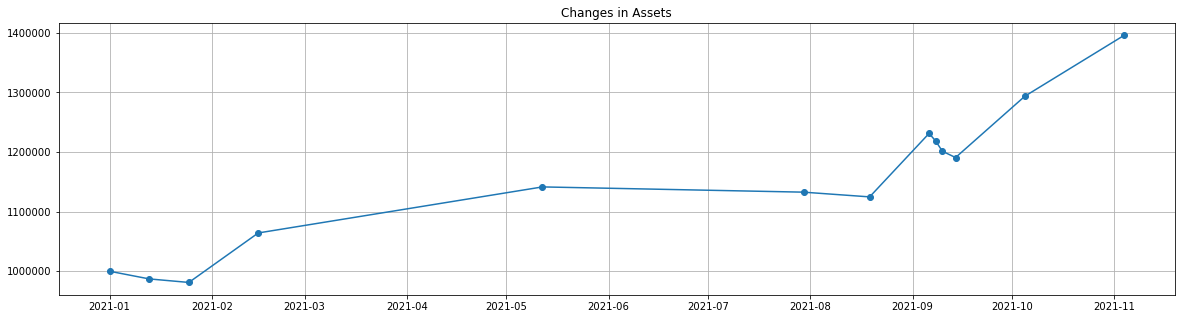

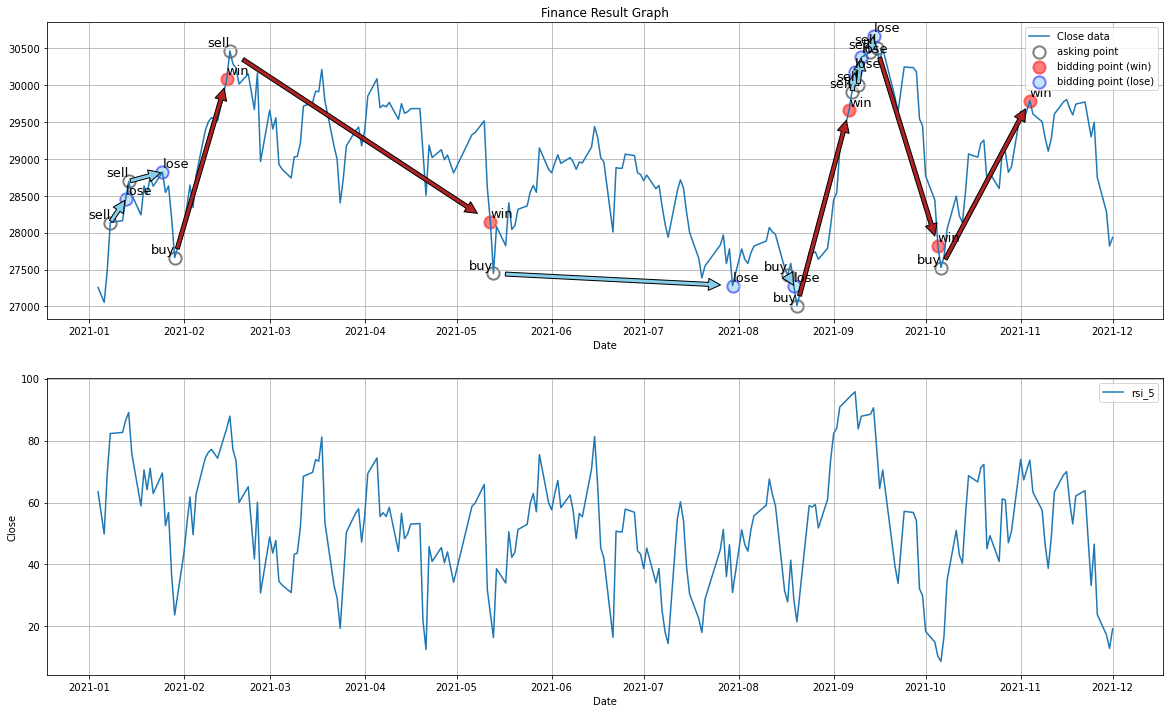

In [141]:
use_data = 'logic00092'
asset, cnt_win, cnt_lose, data_result = check_price(data_technical, use_data=use_data)
display(data_result)
data_plot_asset(data_result)
data_plot_info(data_technical, data_result, data_graph, use_data=use_data)

In [142]:
# 変数名をそのままprint関数内で表示させる関数
def chkprint(*args):
    for obj in args:
        for k, v in globals().items():
            if id(v) == id(obj):
                target = k
                break          
    return target

# データがどのデータ型か、列数、行数を表示する関数
def typeInfo(targetData):
    if (type(targetData) is pd.core.frame.DataFrame):
        print("{} は DataFrame型".format(chkprint(targetData)))
        print("{} の行数, 列数・・・{}\n".format(chkprint(targetData), targetData.shape))     # shapeの表示内容は、(行数, 列数)となる
    if (type(targetData) is list):
        print("{} は list型".format(chkprint(targetData)))
        print("{} の行数, 列数・・・{}\n".format(chkprint(targetData), pd.DataFrame(targetData).shape))    # shapeの表示内容は、(行数, 列数)となる
    if (type(targetData) is np.ndarray):
        print("{} は ndarray型".format(chkprint(targetData)))
        print("{} の行数, 列数・・・{}\n".format(chkprint(targetData), targetData.shape))     # shapeの表示内容は、(行数, 列数)となる
    if (type(targetData) is pd.core.series.Series):
        print("{} は Series型".format(chkprint(targetData)))
        print("{} の行数, 列数・・・{}\n".format(chkprint(targetData), targetData.shape))     # shapeの表示内容は、(行数, 列数)となる

## 機械学習

In [11]:
# 開始日時と終了日時
start, end = '2021-01-01', '2021-12-01'

df_train=[]
df_test=[]

def Train_Test(data,train_start,train_end,test_start,test_end):
#     drop=['level_0']
#     data = data.drop(columns=drop,axis=1) 
    
    data.reset_index(drop=False, inplace=True)
    
    train_start_timestamp= pd.to_datetime(train_start)
    train_end_timestamp= pd.to_datetime(train_end)
    test_start_timestamp= pd.to_datetime(test_start)
    test_end_timestamp= pd.to_datetime(test_end)

    data = data.set_index('Date')
    
    df_train = data.loc[train_start_timestamp:train_end_timestamp, :]
    df_test = data.loc[test_start_timestamp:test_end_timestamp, :]
    
#     df_train.reset_index(drop=False, inplace=True)
#     df_test.reset_index(drop=False, inplace=True)
    
#     data['idx_technical'] = data.index
    return df_train,df_test

def Column_selec(df_train,df_test):
    df_train=df_train[['High','Low','Open','Close']]   
    df_test=df_test[['High','Low','Open','Close']]
    print(f'df_train数 : {len(df_train)}\n')
    print(f'df_train\n{df_train}\n')
    print(f'df_test数 : {len(df_test)}\n')
    print(f'df_test\n{df_test}\n')
    return df_train,df_test


In [12]:
df_train,df_test=Train_Test(data=data_master,train_start='2000-01-01',train_end='2020-12-31',test_start='2021-01-01',test_end='2021-12-01')

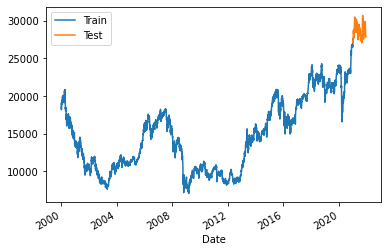

In [13]:
# 学習データのCloseの描画
df_train['Close'].plot(kind='line')
# 評価データのCloseの描画
df_test['Close'].plot(kind='line')
# 折れ線グラフの凡例を表示
plt.legend(['Train', 'Test'])
# 描画の実行
plt.show()

In [14]:
df_train,df_test=Column_selec(df_train,df_test)

df_train数 : 5146

df_train
                    High           Low          Open         Close
Date                                                              
2000-01-04  19187.609375  18937.449219  18937.449219  19002.859375
2000-01-05  19003.509766  18221.820312  19003.509766  18542.550781
2000-01-06  18582.740234  18168.269531  18574.009766  18168.269531
2000-01-07  18285.730469  18068.099609  18194.050781  18193.410156
2000-01-11  18887.560547  18246.099609  18246.099609  18850.919922
...                  ...           ...           ...           ...
2020-12-24  26764.529297  26605.259766  26635.109375  26668.349609
2020-12-25  26716.609375  26638.279297  26708.099609  26656.609375
2020-12-28  26854.029297  26664.599609  26691.289062  26854.029297
2020-12-29  27602.519531  26921.140625  26936.380859  27568.150391
2020-12-30  27572.570312  27338.560547  27559.099609  27444.169922

[5146 rows x 4 columns]

df_test数 : 224

df_test
                    High           Low          Open

## LSTM

In [30]:
# windowを設定
window_len=20

# モデルの定義
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

class MyLSTM:
    
    def __init__(self, params=None):
        if params is None:
            self.params = {}
        else:
            self.params = params
        self.scaler = None
        self.model = None
        self.learn_history = None
        self.input_shape = None
        
    def build_model(self,inputs, output_size=1, neurons=20, activ_func="linear",
                    dropout=0.25, loss="mae", optimizer="adam"):             
        self.model = Sequential()
        self.model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]))) #バッチ数、時系列データ数、特徴量数
        self.model.add(Dropout(dropout)) 
        self.model.add(Dense(units=output_size))
        self.model.add(Activation(activ_func))

        self.model.compile(loss=loss, optimizer=optimizer)
        return
    
    def fit(self, x_train,y_train):
        self.learn_history = self.model.fit(x_train, y_train, 
                            epochs=5, batch_size=1, verbose=2, shuffle=False)
        self.plot_MAE()
        return

    def plot_MAE(self):       
        # MAEをプロットしてみよう
        fig, ax1 = plt.subplots(1,1)

        ax1.plot(self.learn_history.epoch, self.learn_history.history['loss'])
        ax1.set_title('TrainingError')

        if self.model.loss == 'mae':
            ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
        else:
            ax1.set_ylabel('Model Loss',fontsize=12)
        ax1.set_xlabel('# Epochs',fontsize=12)
        plt.show()                        
        return    
        
    def predict(self, x):
        # 予測
        y_pred = self.model.predict(x)
#         y_pred = y_pred.flatten()
        return y_pred

    def Scaling_input(self,data,adjustment1):
#         data.reset_index(drop=True, inplace=True)
        data_lstm_in=[]
        if len(data)==window_len:
            temp = data[:window_len].copy()
            temp = temp / temp.iloc[0] - 1
            data_lstm_in.append(temp)
        for i in range(len(data) - window_len+adjustment1): #今回のLSTMで生成する時系列データ数(train総数-6個のモデル)    
            temp = data[i:(i + window_len)].copy() #windowの単位で行を取得。参照渡しでなく値渡し。
            temp = temp / temp.iloc[0] - 1
            data_lstm_in.append(temp)
        
        data_lstm_in=self.Ndarray_conversion(data_lstm_in)
        return data_lstm_in

    def Scaling_output(self,data):
        lstm_train_out=[]
        lstm_train_out=(data['Close'][window_len:].values / data['Close'][:-window_len].values)-1
        return lstm_train_out

    def Ndarray_conversion(self,data_in):
        array_data=[np.array(data_input) for data_input in data_in]
        array_data = np.array(array_data)
        return array_data

    def Predected_data_inversion(self,df_base,pred):
        Pred_inversion=(np.transpose(pred+1)* df_base['Close'].values[:-window_len])[0]
        return Pred_inversion

    def Actual_data_inversion(self,base,data):
        Actual_inversion=(1+data)* base['Close'].values[:-window_len]
        return Actual_inversion

    def Date_merge(self,base,data):
        
        base2=base.copy()
#         drop=['level_0']
#         base2 = base2.drop(columns=drop,axis=1) 
        base2.reset_index(drop=False, inplace=True)
        
        base2=base2[window_len:]
        
        data2=pd.DataFrame(data)
        
        merge=list(zip(base2['Date'],base2['High'],base2['Low'],base2['Open'],base2['Close'],data2[0]))
        df_merge=pd.DataFrame(merge, columns=['Date','High','Low','Open','Close','Pred_Close'])
        
        df_merge = df_merge.set_index('Date')
          
        return df_merge

    def Date_merge2(self,base,data):    
        base2=base.copy()
#         drop=['level_0']
#         base2 = base2.drop(columns=drop,axis=1) 
        base2.reset_index(drop=False, inplace=True)
        
        base_date=base2[window_len:]
        data2=pd.DataFrame(data)
        
        data_with_date=list(zip(base_date['Date'],data2[0]))
        df_pred=pd.DataFrame(data_with_date, columns=['Date','Pred_Close'])
        df_pred.set_index('Date',inplace=True)
        
        base2.set_index('Date',inplace=True)
               
        df_Merged=pd.concat([df_pred,base2], axis=1)
          
        return df_Merged    
    

In [31]:
mylstm_model_1=MyLSTM()

In [20]:
train_lstm_in = mylstm_model_1.Scaling_input(data=df_train,adjustment1=0)
lstm_train_out= mylstm_model_1.Scaling_output(df_train)

test_lstm_in = mylstm_model_1.Scaling_input(data=df_test,adjustment1=0)
lstm_test_out= mylstm_model_1.Scaling_output(df_test)

In [46]:
len(train_lstm_in)

5126

Epoch 1/5
5126/5126 - 14s - loss: 0.0174
Epoch 2/5
5126/5126 - 14s - loss: 0.0139
Epoch 3/5
5126/5126 - 14s - loss: 0.0133
Epoch 4/5
5126/5126 - 14s - loss: 0.0132
Epoch 5/5
5126/5126 - 13s - loss: 0.0131


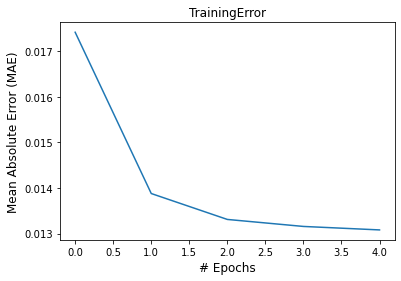

In [21]:
mylstm_model_1.build_model(train_lstm_in)
mylstm_model_1.fit(train_lstm_in, lstm_train_out)

In [22]:
train_pred=mylstm_model_1.predict(train_lstm_in)

Pred_Train_Price_Array=mylstm_model_1.Predected_data_inversion(df_train,train_pred)
Actual_Train_Price_Array=mylstm_model_1.Actual_data_inversion(df_train,lstm_train_out)

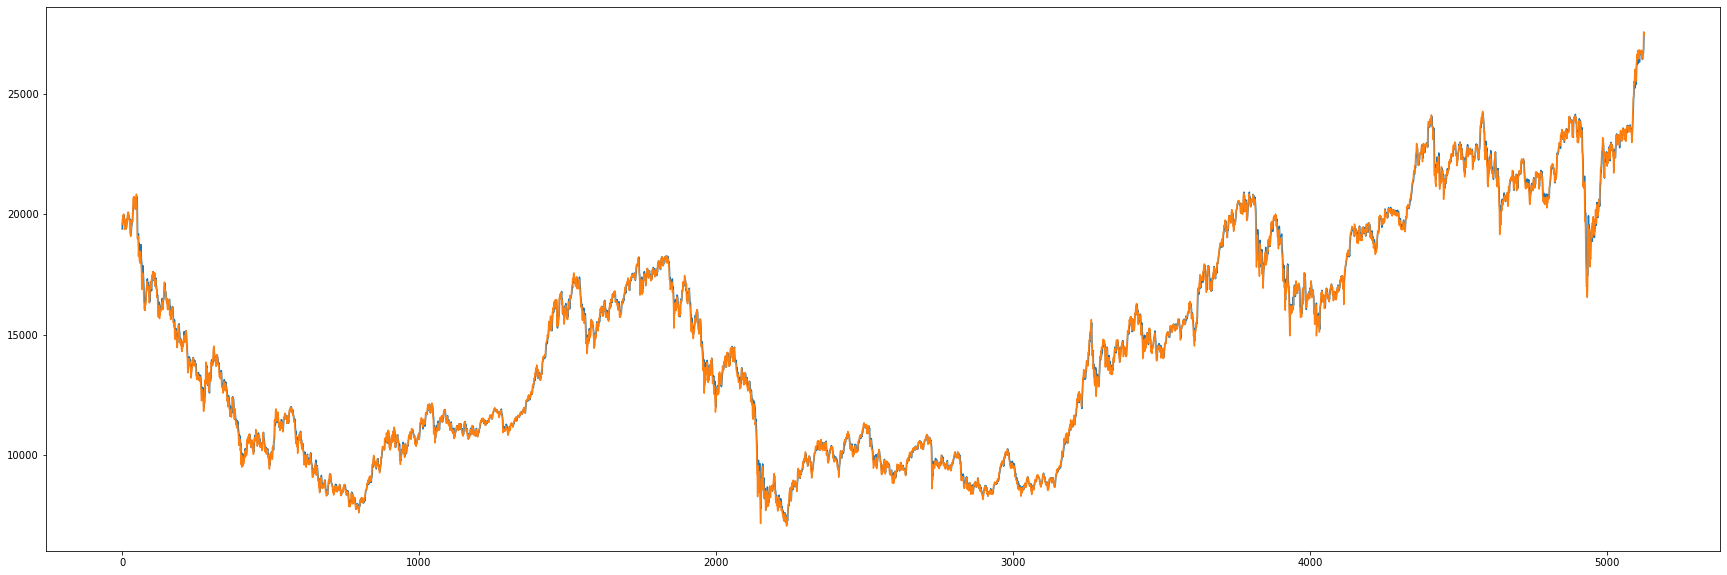

In [45]:
fig,ax = plt.subplots(figsize=(30,10))

# 予測データと正解データの併記
ax.plot(Pred_Train_Price_Array)
ax.plot(Actual_Train_Price_Array)

# fig,ax = plt.subplots(figsize=(30,10))
# # fig,ax = plt.subplots()

# # 正解データと予測データの併記
# ax.plot(Pred_Price_Array)
# ax.plot(Actual_Price_Array)


In [24]:
test_pred=mylstm_model_1.predict(test_lstm_in)

Actual_Price_Array=mylstm_model_1.Actual_data_inversion(df_test,lstm_test_out)
Pred_Price_Array=mylstm_model_1.Predected_data_inversion(df_test,test_pred)

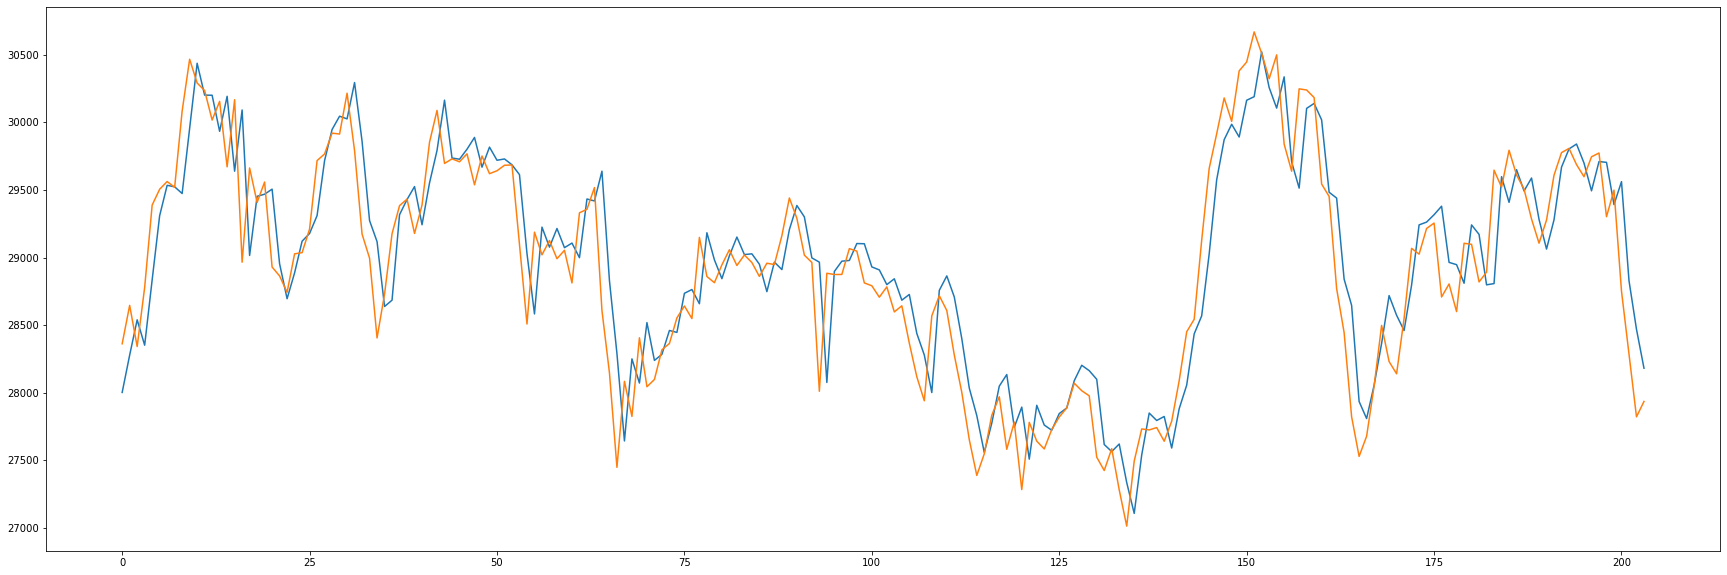

In [43]:
fig,ax = plt.subplots(figsize=(30,10))
# fig,ax = plt.subplots()

# 正解データと予測データの併記
ax.plot(Pred_Price_Array)
ax.plot(Actual_Price_Array)
plt.show()

In [38]:
output=mylstm_model_1.Date_merge2(df_test,Pred_Price_Array)
output.to_csv('combination.csv')
output

,Pred_Close,High,Low,Open,Close
Date,,,,,
2021-01-04,NaN,27602.109375,27042.320312,27575.570312,27258.380859
2021-01-05,NaN,27279.779297,27073.460938,27151.380859,27158.630859
2021-01-06,NaN,27196.400391,27002.179688,27102.849609,27055.939453
2021-01-07,NaN,27624.730469,27340.460938,27340.460938,27490.130859
2021-01-08,NaN,28139.029297,27667.750000,27720.140625,28139.029297
...,...,...,...,...,...
2021-11-25,29392.260572,29570.419922,29444.449219,29469.650391,29499.279297
2021-11-26,29562.085569,29332.990234,28605.609375,29324.470703,28751.619141
2021-11-29,28829.579033,28776.339844,28187.119141,28337.960938,28283.919922
